# Modules

In [81]:
from lib import wrappers
from lib import dqn_model
import time
import numpy as np
import collections
import matplotlib as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tensorboardX import SummaryWriter

# Constants

In [82]:
DEFAULT_ENV_NAME = "PongNoFrameskip-v4"
MEAN_REWARD_BOUND = 19.5
EPSILON_DECAY_LAST_FRAME = 10**5
EPSILON_START = 1.0
EPSILON_FINAL = 0.02
GAMMA = 0.99
BATCH_SIZE = 32
REPLAY_SIZE = 10000
LEARNING_RATE = 0.0001
SYNC_TARGET_FRAMES = 1000
REPLAY_START_SIZE = 10000

# Classes

Experienced Buffer

In [83]:
Experience = collections.namedtuple('Experience', field_names=['state', 'action', 'reward', 'done', 'new_state'])

class ExperienceBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), np.array(next_states)



Agent

In [84]:
class Agent:
    def __init__(self, env, exp_buffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self._reset()

    def _reset(self):
        self.state = env.reset()
        self.total_reward = 0.0

    def play_step(self, net, epsilon=0.0, device="cpu"):
        done_reward = None

        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            state_a = np.array([self.state], copy=False)
            state_v = torch.tensor(state_a).to(device)
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v, dim=1)
            action = int(act_v.item())

        # do step in the environment
        new_state, reward, is_done, _ = self.env.step(action)
        self.total_reward += reward

        exp = Experience(self.state, action, reward, is_done, new_state)
        self.exp_buffer.append(exp)
        self.state = new_state
        if is_done:
            done_reward = self.total_reward
            self._reset()
        return done_reward

# Loss Calculations

In [85]:
def calc_loss(batch, net, tgt_net, device="cpu"):
    states, actions, rewards, dones, next_states = batch

    states_v = torch.tensor(states).to(device)
    next_states_v = torch.tensor(next_states).to(device)
    actions_v = torch.tensor(actions).to(device)
    rewards_v = torch.tensor(rewards).to(device)
    done_mask = torch.ByteTensor(dones).to(device)

    actions_v2 = actions_v.unsqueeze(-1).long()

    state_action_values = net(states_v).gather(1, actions_v2).squeeze(-1)
    
    next_state_values = tgt_net(next_states_v).max(1)[0]
    next_state_values[done_mask] = 0.0
    next_state_values = next_state_values.detach()

    expected_state_action_values = next_state_values * GAMMA + rewards_v
    return nn.MSELoss()(state_action_values, expected_state_action_values)

# New Main

DQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)
3366 frames over 1 games, mean reward -20.000, eps 0.97, speed 901.65 f/s
7212 frames over 2 games, mean reward -20.000, eps 0.93, speed 767.57 f/s


C:\Users\james\AppData\Local\Temp\ipykernel_1892\98137925.py:15: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cuda\Indexing.cu:967.)
  next_state_values[done_mask] = 0.0


10507 frames over 3 games, mean reward -20.333, eps 0.89, speed 274.52 f/s
13873 frames over 4 games, mean reward -20.250, eps 0.86, speed 64.03 f/s
17359 frames over 5 games, mean reward -20.200, eps 0.83, speed 66.79 f/s
21270 frames over 6 games, mean reward -20.000, eps 0.79, speed 66.87 f/s
25027 frames over 7 games, mean reward -19.857, eps 0.75, speed 67.43 f/s
Best mean reward updated -20.000 -> -19.857, model saved
28082 frames over 8 games, mean reward -20.000, eps 0.72, speed 65.55 f/s
31137 frames over 9 games, mean reward -20.111, eps 0.69, speed 65.89 f/s
34192 frames over 10 games, mean reward -20.200, eps 0.66, speed 67.39 f/s
37247 frames over 11 games, mean reward -20.273, eps 0.63, speed 67.01 f/s
41041 frames over 12 games, mean reward -20.250, eps 0.59, speed 66.92 f/s
45034 frames over 13 games, mean reward -20.154, eps 0.55, speed 65.91 f/s
48644 frames over 14 games, mean reward -20.214, eps 0.51, speed 66.04 f/s
51943 frames over 15 games, mean reward -20.267, 

ValueError: x and y must have same first dimension, but have shapes (39341,) and (500,)

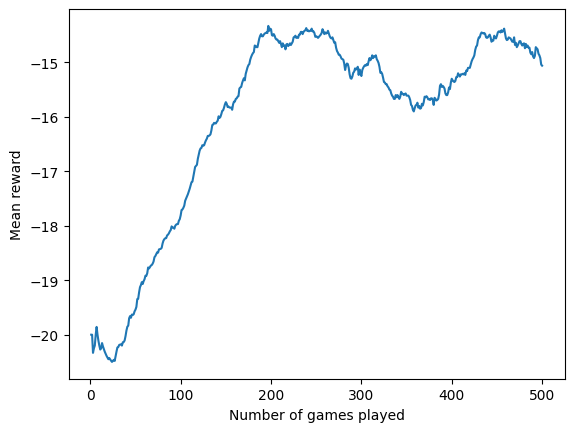

In [90]:

from lib import wrappers_skips
import matplotlib.pyplot as plt
# device = torch.device("gpu")
device = torch.device("cuda")

for i in range(8):
    env = wrappers_skips.make_env(DEFAULT_ENV_NAME, i+1)

    net = dqn_model.DQN(env.observation_space.shape, env.action_space.n).to(device)
    tgt_net = dqn_model.DQN(env.observation_space.shape, env.action_space.n).to(device)
    writer = SummaryWriter(comment="-" + DEFAULT_ENV_NAME)
    print(net)

    buffer = ExperienceBuffer(REPLAY_SIZE)
    agent = Agent(env, buffer)
    epsilon = EPSILON_START

    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
    total_rewards = []
    frame_idx = 0
    ts_frame = 0
    ts = time.time()
    best_mean_reward = None

    NUM_GAMES = 500

    # for plots
    mean_rewards = []
    num_games = []
    epsilons = []
    frames = []


    while len(total_rewards) < NUM_GAMES:
        frame_idx += 1
        epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / EPSILON_DECAY_LAST_FRAME)
        if frame_idx % 100 == 0:
            epsilons.append(epsilon)
            frames.append(frame_idx)

        reward = agent.play_step(net, epsilon, device=device)
        if reward is not None:
        # if reward is not None and reward > 0:
            total_rewards.append(reward)
            speed = (frame_idx - ts_frame) / (time.time() - ts)
            ts_frame = frame_idx
            ts = time.time()
            mean_reward = np.mean(total_rewards[-100:])
            mean_rewards.append(mean_reward)
            num_games.append(len(total_rewards))
            print("%d frames over %d games, mean reward %.3f, eps %.2f, speed %.2f f/s" % (
                frame_idx, len(total_rewards), mean_reward, epsilon,
                speed
            ))
            writer.add_scalar("epsilon", epsilon, frame_idx)
            writer.add_scalar("speed", speed, frame_idx)
            writer.add_scalar("reward_100", mean_reward, frame_idx)
            writer.add_scalar("reward", reward, frame_idx)
            if best_mean_reward is None or best_mean_reward < mean_reward:
                torch.save(net.state_dict(), DEFAULT_ENV_NAME + '_skip' + str(i) + "-best.dat")
                if best_mean_reward is not None:
                    print("Best mean reward updated %.3f -> %.3f, model saved" % (best_mean_reward, mean_reward))
                best_mean_reward = mean_reward
            if mean_reward > MEAN_REWARD_BOUND:
                print("Solved in %d frames!" % frame_idx)
                break

        if len(buffer) < REPLAY_START_SIZE:
            continue

        if frame_idx % SYNC_TARGET_FRAMES == 0:
            tgt_net.load_state_dict(net.state_dict())

        optimizer.zero_grad()
        batch = buffer.sample(BATCH_SIZE)
        loss_t = calc_loss(batch, net, tgt_net, device=device)
        loss_t.backward()
        optimizer.step()

    writer.close()

    plt.plot(num_games, mean_rewards)
    plt.xlabel('Number of games played')
    plt.ylabel('Mean reward')
    plt.savefig('mr_sk ' + str(i) + '.png')

    plt.plot(frames, mean_rewards)
    plt.xlabel('Number of games played')
    plt.ylabel('Mean reward')
    plt.savefig('fr_sk ' + str(i) + '.png')

    plt.plot(range(1, len(total_rewards)+1), total_rewards)
    plt.xlabel('Number of games played')
    plt.ylabel('Total reward')
    plt.savefig('tr_sk ' + str(i) + '.png')

    plt.hist(total_rewards, bins=30)
    plt.xlabel('Reward')
    plt.ylabel('Count')
    plt.savefig('r_sk ' + str(i) + '.png')


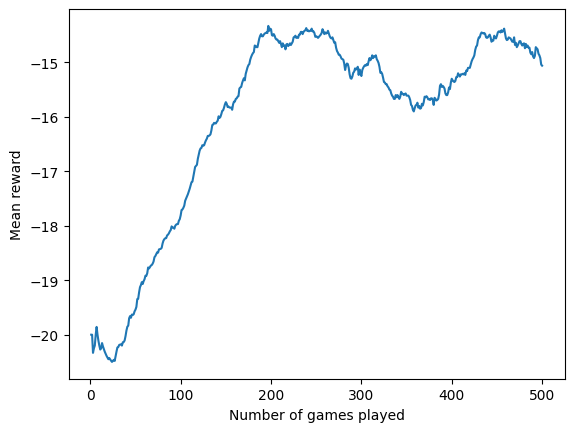

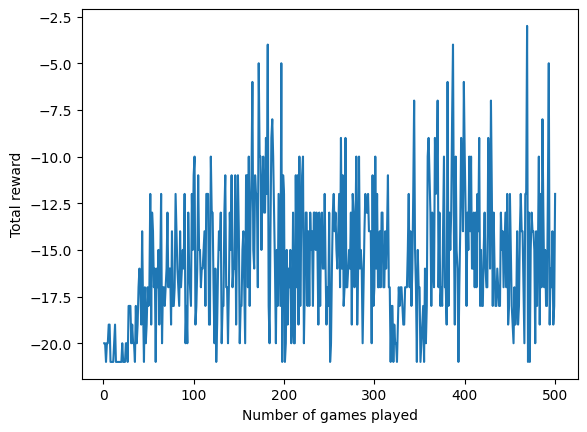

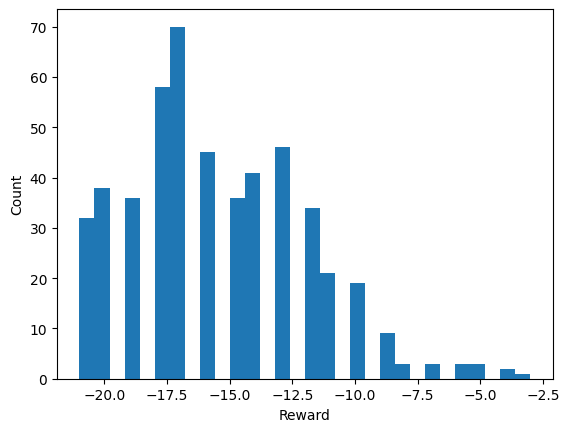

<Figure size 640x480 with 0 Axes>

In [92]:
plt.plot(num_games, mean_rewards)
plt.xlabel('Number of games played')
plt.ylabel('Mean reward')
plt.show()
plt.savefig('mr_sk ' + str(i) + '.png')


plt.plot(range(1, len(total_rewards)+1), total_rewards)
plt.xlabel('Number of games played')
plt.ylabel('Total reward')
plt.show()
plt.savefig('tr_sk ' + str(i) + '.png')

plt.hist(total_rewards, bins=30)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.show()
plt.savefig('r_sk ' + str(i) + '.png')

# Main

DQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)
412 frames over 1 games, mean reward -20.000, eps 1.00, speed 326.75 f/s
790 frames over 2 games, mean reward -20.500, eps 0.99, speed 284.20 f/s
1156 frames over 3 games, mean reward -20.667, eps 0.99, speed 288.99 f/s
1566 frames over 4 games, mean reward -20.500, eps 0.98, speed 299.85 f/s
1972 frames over 5 games, mean reward -20.400, eps 0.98, speed 306.25 f/s
2410 frames over 6 games, mean reward -20.333, eps 0.98, speed 302.21 f/s
2796 frames over 7 games, mean reward -20.429, eps 0.97, speed 291.48 f/s
3194 frames over 8 games, mean reward -20.375, eps 0.97, speed 2

C:\Users\james\AppData\Local\Temp\ipykernel_1892\98137925.py:15: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cuda\Indexing.cu:967.)
  next_state_values[done_mask] = 0.0


10166 frames over 26 games, mean reward -20.615, eps 0.90, speed 70.63 f/s
10504 frames over 27 games, mean reward -20.630, eps 0.89, speed 31.60 f/s
10877 frames over 28 games, mean reward -20.643, eps 0.89, speed 38.14 f/s
11295 frames over 29 games, mean reward -20.621, eps 0.89, speed 42.61 f/s
11740 frames over 30 games, mean reward -20.567, eps 0.88, speed 47.68 f/s
12196 frames over 31 games, mean reward -20.516, eps 0.88, speed 49.17 f/s
12664 frames over 32 games, mean reward -20.500, eps 0.87, speed 49.67 f/s
13092 frames over 33 games, mean reward -20.485, eps 0.87, speed 51.61 f/s
13438 frames over 34 games, mean reward -20.500, eps 0.87, speed 54.30 f/s
13776 frames over 35 games, mean reward -20.514, eps 0.86, speed 55.13 f/s
14204 frames over 36 games, mean reward -20.528, eps 0.86, speed 58.75 f/s
14638 frames over 37 games, mean reward -20.514, eps 0.85, speed 58.38 f/s
15085 frames over 38 games, mean reward -20.500, eps 0.85, speed 57.04 f/s
15483 frames over 39 game

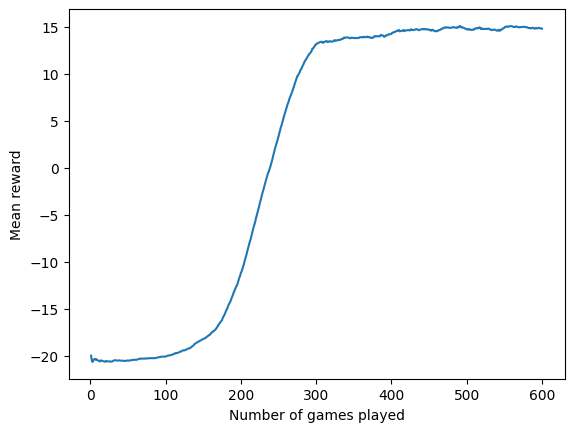

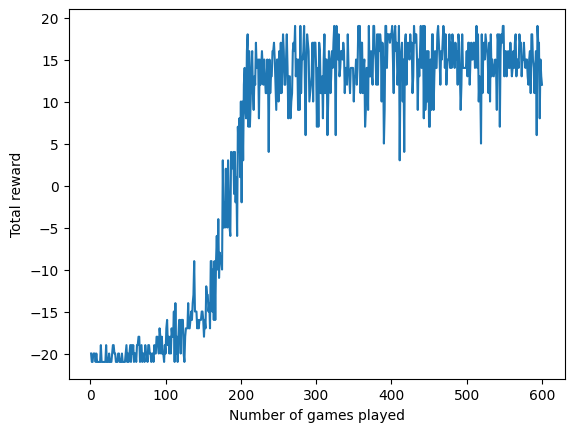

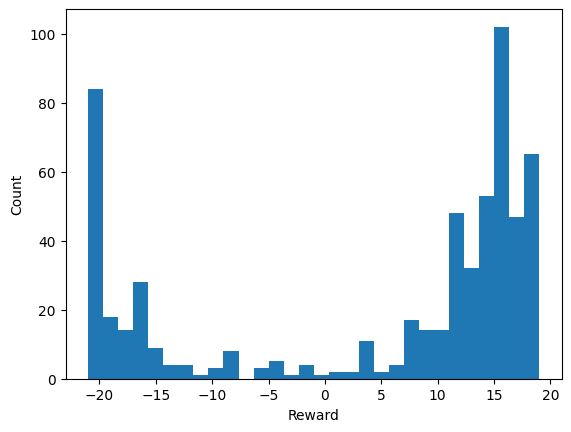

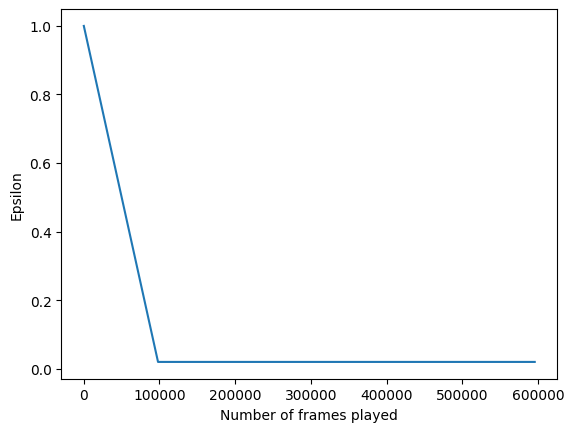

In [107]:

import matplotlib.pyplot as plt
from lib import wrappers_skips
# device = torch.device("gpu")
device = torch.device("cuda")

env = wrappers_skips.make_env(DEFAULT_ENV_NAME, 9)

net = dqn_model.DQN(env.observation_space.shape, env.action_space.n).to(device)
tgt_net = dqn_model.DQN(env.observation_space.shape, env.action_space.n).to(device)
writer = SummaryWriter(comment="-" + DEFAULT_ENV_NAME)
print(net)

buffer = ExperienceBuffer(REPLAY_SIZE)
agent = Agent(env, buffer)
epsilon = EPSILON_START

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
total_rewards = []
frame_idx = 0
ts_frame = 0
ts = time.time()
best_mean_reward = None

NUM_GAMES = 600

# for plots
mean_rewards = []
num_games = []
epsilons = []
frames = []


while len(total_rewards) < NUM_GAMES:
    frame_idx += 1
    epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / EPSILON_DECAY_LAST_FRAME)
    if frame_idx % 100 == 0:
        epsilons.append(epsilon)
        frames.append(frame_idx)

    reward = agent.play_step(net, epsilon, device=device)
    if reward is not None:
    # if reward is not None and reward > 0:
        total_rewards.append(reward)
        speed = (frame_idx - ts_frame) / (time.time() - ts)
        ts_frame = frame_idx
        ts = time.time()
        mean_reward = np.mean(total_rewards[-100:])
        mean_rewards.append(mean_reward)
        num_games.append(len(total_rewards))
        print("%d frames over %d games, mean reward %.3f, eps %.2f, speed %.2f f/s" % (
            frame_idx, len(total_rewards), mean_reward, epsilon,
            speed
        ))
        writer.add_scalar("epsilon", epsilon, frame_idx)
        writer.add_scalar("speed", speed, frame_idx)
        writer.add_scalar("reward_100", mean_reward, frame_idx)
        writer.add_scalar("reward", reward, frame_idx)
        if best_mean_reward is None or best_mean_reward < mean_reward:
            torch.save(net.state_dict(), DEFAULT_ENV_NAME + "-best.dat")
            if best_mean_reward is not None:
                print("Best mean reward updated %.3f -> %.3f, model saved" % (best_mean_reward, mean_reward))
            best_mean_reward = mean_reward
        if mean_reward > MEAN_REWARD_BOUND:
            print("Solved in %d frames!" % frame_idx)
            break

    if len(buffer) < REPLAY_START_SIZE:
        continue

    if frame_idx % SYNC_TARGET_FRAMES == 0:
        tgt_net.load_state_dict(net.state_dict())

    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE)
    loss_t = calc_loss(batch, net, tgt_net, device=device)
    loss_t.backward()
    optimizer.step()

writer.close()

plt.plot(num_games, mean_rewards)
plt.xlabel('Number of games played')
plt.ylabel('Mean reward')
plt.show()

plt.plot(range(1, len(total_rewards)+1), total_rewards)
plt.xlabel('Number of games played')
plt.ylabel('Total reward')
plt.show()

plt.hist(total_rewards, bins=30)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.show()

plt.plot(frames, epsilons)
plt.xlabel('Number of frames played')
plt.ylabel('Epsilon')
plt.show()


In [108]:

import matplotlib.pyplot as plt
from lib import wrappers_skips
# device = torch.device("gpu")
device = torch.device("cuda")

env = wrappers_skips.make_env(DEFAULT_ENV_NAME, 3)

net = dqn_model.DQN(env.observation_space.shape, env.action_space.n).to(device)
tgt_net = dqn_model.DQN(env.observation_space.shape, env.action_space.n).to(device)
writer = SummaryWriter(comment="-" + DEFAULT_ENV_NAME)
print(net)

buffer = ExperienceBuffer(REPLAY_SIZE)
agent = Agent(env, buffer)
epsilon = EPSILON_START

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
total_rewards = []
frame_idx = 0
ts_frame = 0
ts = time.time()
best_mean_reward = None

NUM_GAMES = 900

# for plots
mean_rewards = []
num_games = []
epsilons = []
frames = []


while len(total_rewards) < NUM_GAMES:
    frame_idx += 1
    epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / EPSILON_DECAY_LAST_FRAME)
    if frame_idx % 100 == 0:
        epsilons.append(epsilon)
        frames.append(frame_idx)

    reward = agent.play_step(net, epsilon, device=device)
    if reward is not None:
    # if reward is not None and reward > 0:
        total_rewards.append(reward)
        speed = (frame_idx - ts_frame) / (time.time() - ts)
        ts_frame = frame_idx
        ts = time.time()
        mean_reward = np.mean(total_rewards[-100:])
        mean_rewards.append(mean_reward)
        num_games.append(len(total_rewards))
        print("%d frames over %d games, mean reward %.3f, eps %.2f, speed %.2f f/s" % (
            frame_idx, len(total_rewards), mean_reward, epsilon,
            speed
        ))
        writer.add_scalar("epsilon", epsilon, frame_idx)
        writer.add_scalar("speed", speed, frame_idx)
        writer.add_scalar("reward_100", mean_reward, frame_idx)
        writer.add_scalar("reward", reward, frame_idx)
        if best_mean_reward is None or best_mean_reward < mean_reward:
            torch.save(net.state_dict(), DEFAULT_ENV_NAME + "-skip3.dat")
            if best_mean_reward is not None:
                print("Best mean reward updated %.3f -> %.3f, model saved" % (best_mean_reward, mean_reward))
            best_mean_reward = mean_reward
        if mean_reward > MEAN_REWARD_BOUND:
            print("Solved in %d frames!" % frame_idx)
            break

    if len(buffer) < REPLAY_START_SIZE:
        continue

    if frame_idx % SYNC_TARGET_FRAMES == 0:
        tgt_net.load_state_dict(net.state_dict())

    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE)
    loss_t = calc_loss(batch, net, tgt_net, device=device)
    loss_t.backward()
    optimizer.step()

writer.close()

plt.plot(num_games, mean_rewards)
plt.xlabel('Number of games played')
plt.ylabel('Mean reward')
plt.show()

plt.plot(range(1, len(total_rewards)+1), total_rewards)
plt.xlabel('Number of games played')
plt.ylabel('Total reward')
plt.show()

plt.hist(total_rewards, bins=30)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.show()

plt.plot(frames, epsilons)
plt.xlabel('Number of frames played')
plt.ylabel('Epsilon')
plt.show()


DQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)
1177 frames over 1 games, mean reward -21.000, eps 0.99, speed 657.43 f/s
2466 frames over 2 games, mean reward -20.500, eps 0.98, speed 611.36 f/s
Best mean reward updated -21.000 -> -20.500, model saved
3483 frames over 3 games, mean reward -20.667, eps 0.97, speed 588.24 f/s
4580 frames over 4 games, mean reward -20.750, eps 0.95, speed 561.16 f/s
5966 frames over 5 games, mean reward -20.600, eps 0.94, speed 530.87 f/s
7350 frames over 6 games, mean reward -20.167, eps 0.93, speed 559.06 f/s
Best mean reward updated -20.500 -> -20.167, model saved
8575 frames over 7 gam

C:\Users\james\AppData\Local\Temp\ipykernel_1892\98137925.py:15: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cuda\Indexing.cu:967.)
  next_state_values[done_mask] = 0.0


10687 frames over 9 games, mean reward -20.222, eps 0.89, speed 92.60 f/s
11704 frames over 10 games, mean reward -20.300, eps 0.88, speed 63.62 f/s
13108 frames over 11 games, mean reward -20.182, eps 0.87, speed 65.72 f/s
14448 frames over 12 games, mean reward -20.250, eps 0.86, speed 65.05 f/s
15465 frames over 13 games, mean reward -20.308, eps 0.85, speed 64.28 f/s
16628 frames over 14 games, mean reward -20.357, eps 0.83, speed 63.68 f/s
18099 frames over 15 games, mean reward -20.200, eps 0.82, speed 64.96 f/s
19258 frames over 16 games, mean reward -20.188, eps 0.81, speed 64.17 f/s
20505 frames over 17 games, mean reward -20.118, eps 0.79, speed 63.76 f/s
21967 frames over 18 games, mean reward -20.111, eps 0.78, speed 62.80 f/s
23182 frames over 19 games, mean reward -20.158, eps 0.77, speed 62.95 f/s
24557 frames over 20 games, mean reward -20.200, eps 0.75, speed 63.23 f/s
25678 frames over 21 games, mean reward -20.190, eps 0.74, speed 63.66 f/s
26916 frames over 22 games

# Skip Every 2nd Frame

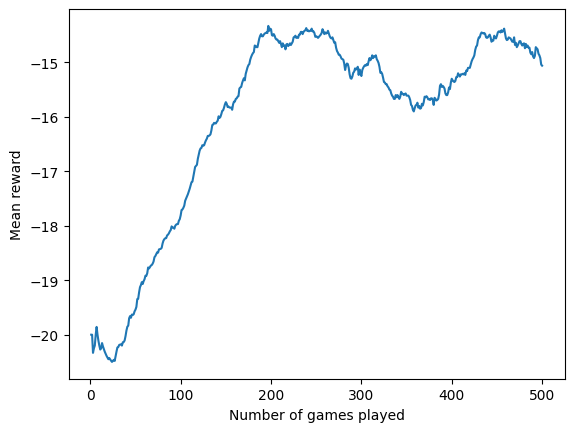

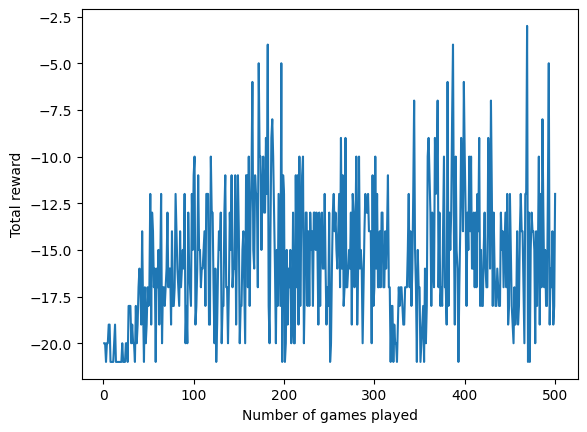

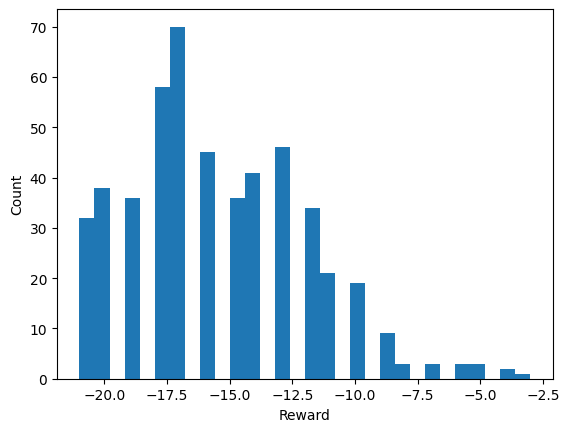

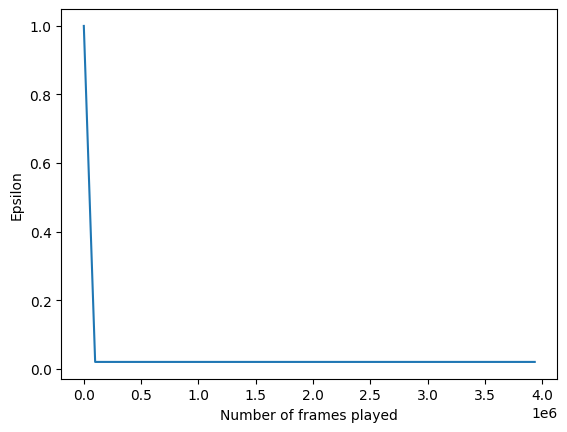

In [93]:
plt.plot(num_games, mean_rewards)
plt.xlabel('Number of games played')
plt.ylabel('Mean reward')
plt.show()

plt.plot(range(1, len(total_rewards)+1), total_rewards)
plt.xlabel('Number of games played')
plt.ylabel('Total reward')
plt.show()

plt.hist(total_rewards, bins=30)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.show()

plt.plot(frames, epsilons)
plt.xlabel('Number of frames played')
plt.ylabel('Epsilon')
plt.show()

# Skip Every 3rd Frame

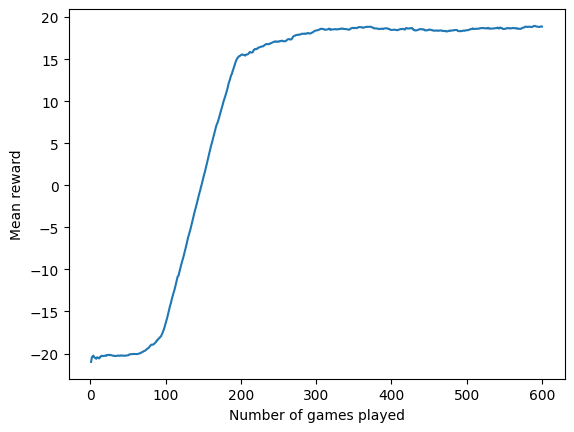

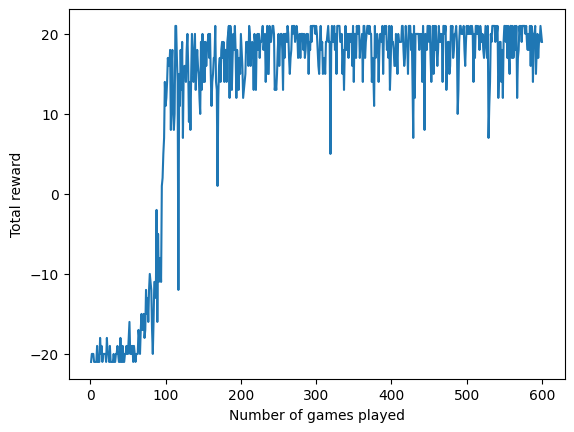

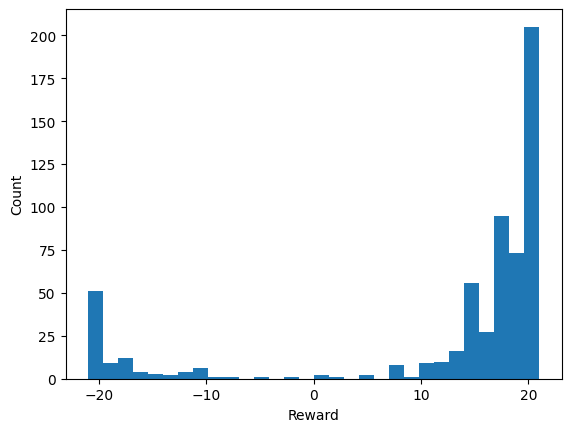

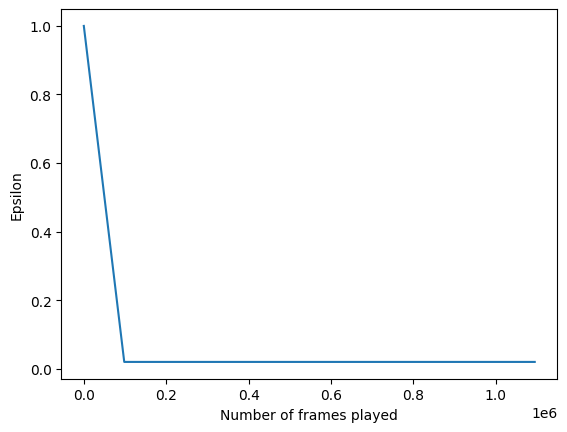

In [80]:
import matplotlib.pyplot as plt
plt.plot(num_games, mean_rewards)
plt.xlabel('Number of games played')
plt.ylabel('Mean reward')
plt.show()

plt.plot(range(1, len(total_rewards)+1), total_rewards)
plt.xlabel('Number of games played')
plt.ylabel('Total reward')
plt.show()

plt.hist(total_rewards, bins=30)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.show()

plt.plot(frames, epsilons)
plt.xlabel('Number of frames played')
plt.ylabel('Epsilon')
plt.show()

# Skip Every 4th Frame

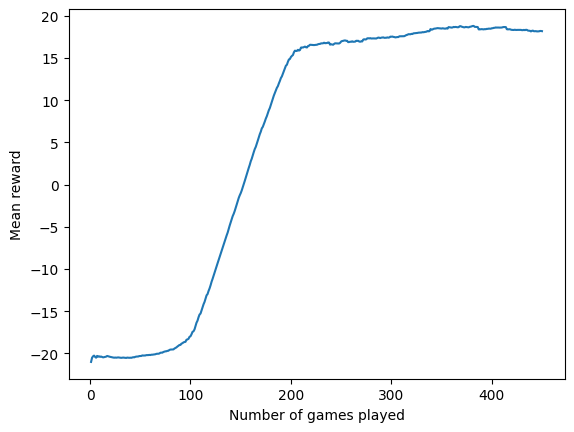

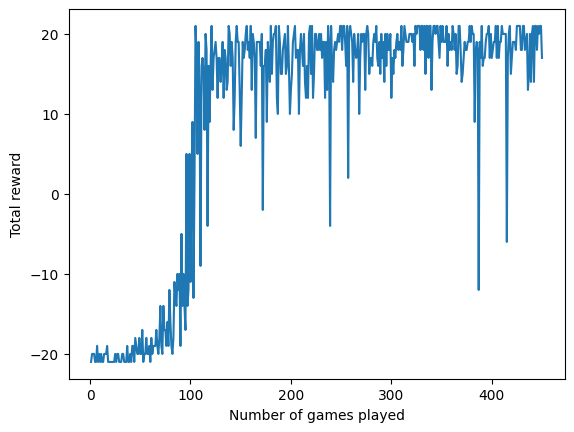

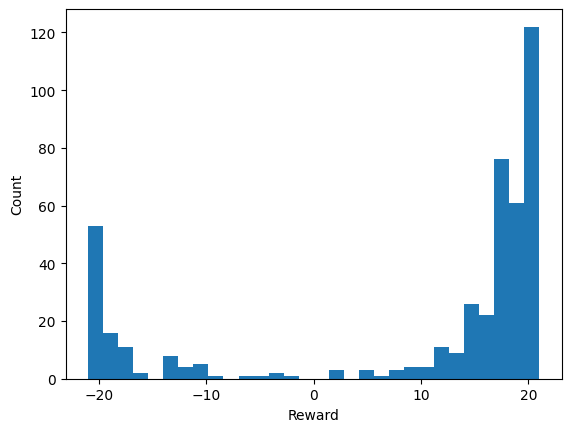

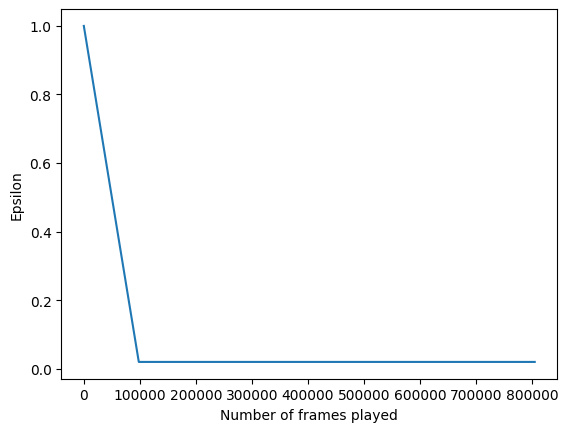

In [50]:
import matplotlib.pyplot as plt
plt.plot(num_games, mean_rewards)
plt.xlabel('Number of games played')
plt.ylabel('Mean reward')
plt.show()

plt.plot(range(1, len(total_rewards)+1), total_rewards)
plt.xlabel('Number of games played')
plt.ylabel('Total reward')
plt.show()

plt.hist(total_rewards, bins=30)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.show()

plt.plot(frames, epsilons)
plt.xlabel('Number of frames played')
plt.ylabel('Epsilon')
plt.show()

# Skip Every 5th Frame

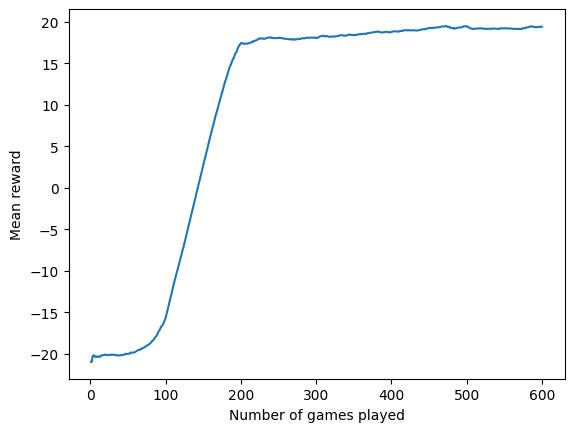

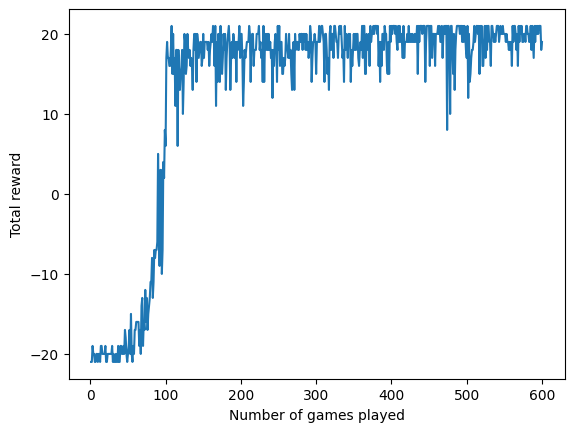

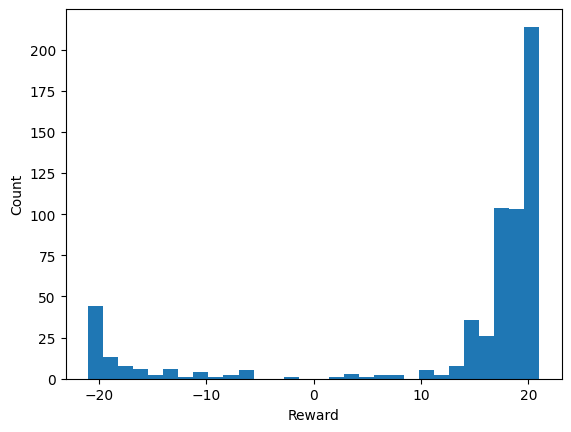

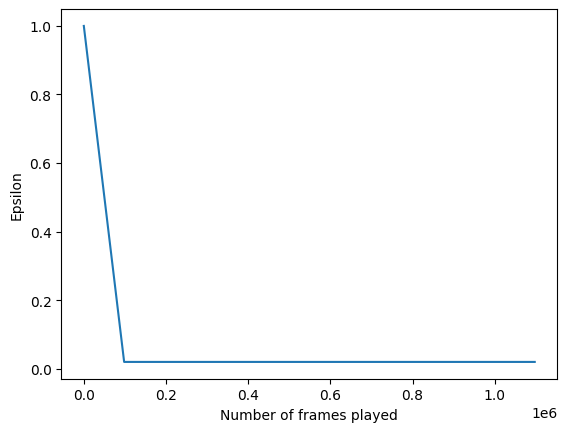

In [71]:
import matplotlib.pyplot as plt
plt.plot(num_games, mean_rewards)
plt.xlabel('Number of games played')
plt.ylabel('Mean reward')
plt.show()

plt.plot(range(1, len(total_rewards)+1), total_rewards)
plt.xlabel('Number of games played')
plt.ylabel('Total reward')
plt.show()

plt.hist(total_rewards, bins=30)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.show()

plt.plot(frames, epsilons)
plt.xlabel('Number of frames played')
plt.ylabel('Epsilon')
plt.show()

# Frame Skip 6th

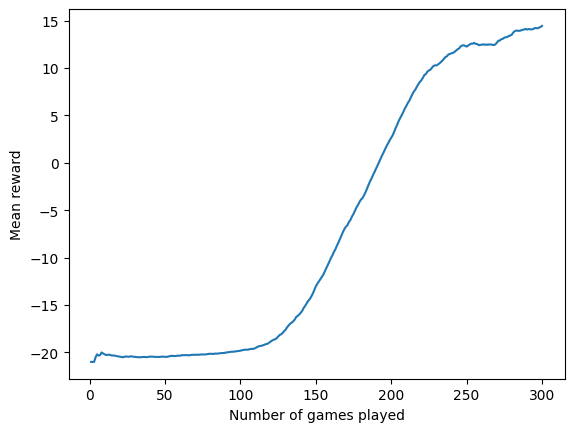

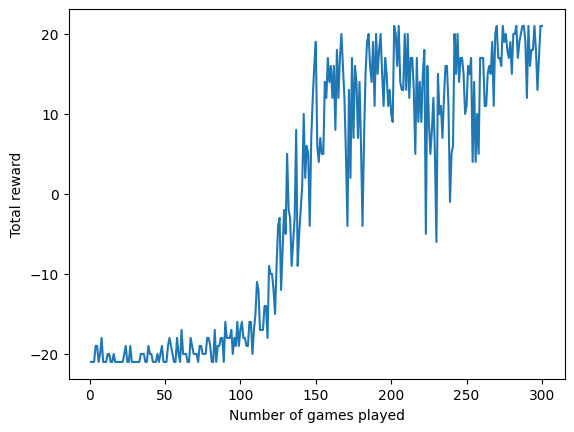

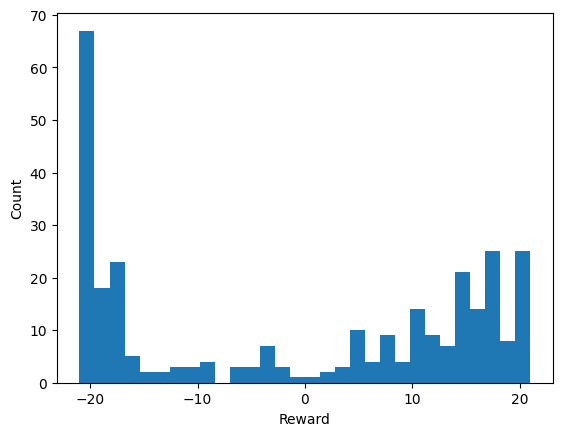

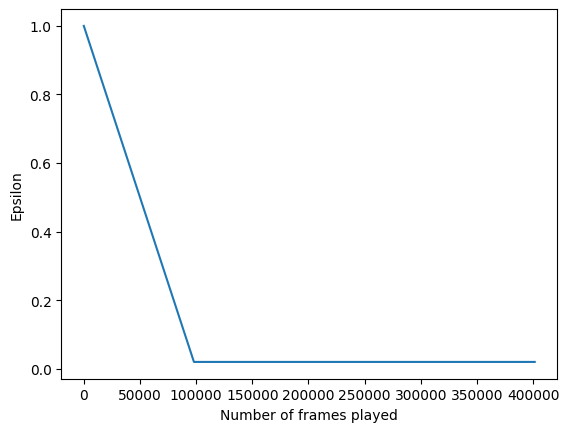

In [99]:
plt.plot(num_games, mean_rewards)
plt.xlabel('Number of games played')
plt.ylabel('Mean reward')
plt.show()

plt.plot(range(1, len(total_rewards)+1), total_rewards)
plt.xlabel('Number of games played')
plt.ylabel('Total reward')
plt.show()

plt.hist(total_rewards, bins=30)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.show()

plt.plot(frames, epsilons)
plt.xlabel('Number of frames played')
plt.ylabel('Epsilon')
plt.show()

# Skip Every 7th Frame

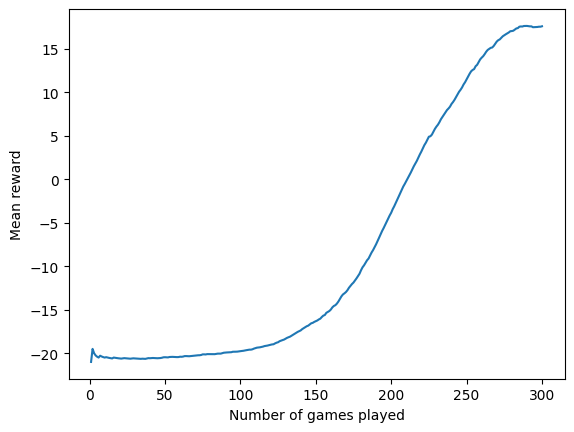

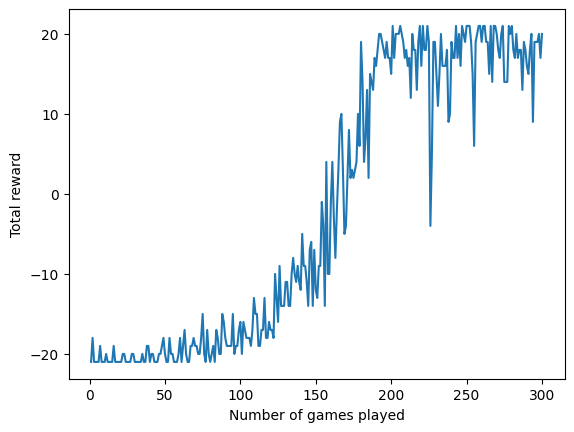

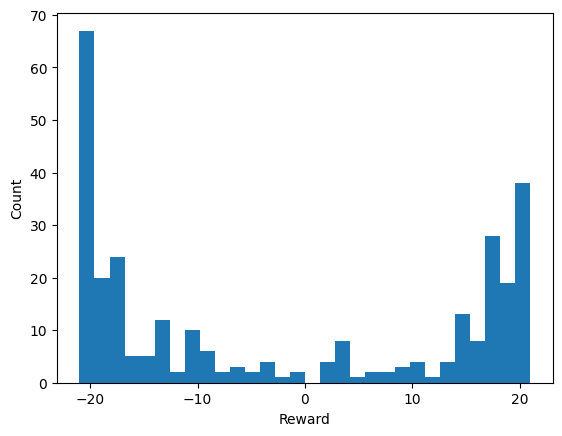

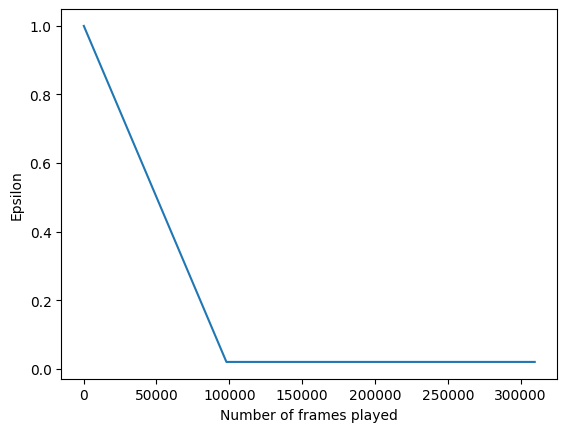

In [101]:
plt.plot(num_games, mean_rewards)
plt.xlabel('Number of games played')
plt.ylabel('Mean reward')
plt.show()

plt.plot(range(1, len(total_rewards)+1), total_rewards)
plt.xlabel('Number of games played')
plt.ylabel('Total reward')
plt.show()

plt.hist(total_rewards, bins=30)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.show()

plt.plot(frames, epsilons)
plt.xlabel('Number of frames played')
plt.ylabel('Epsilon')
plt.show()

# Skip Every 8th Frame

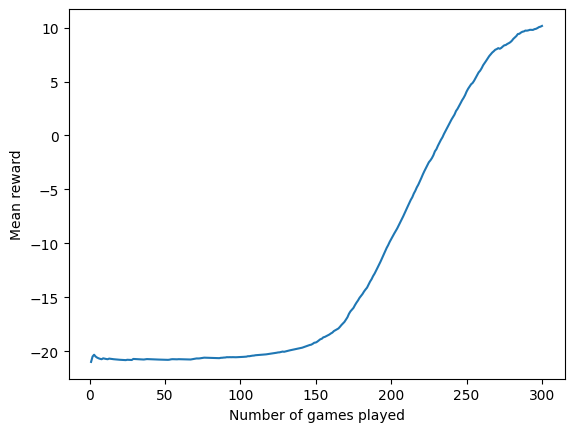

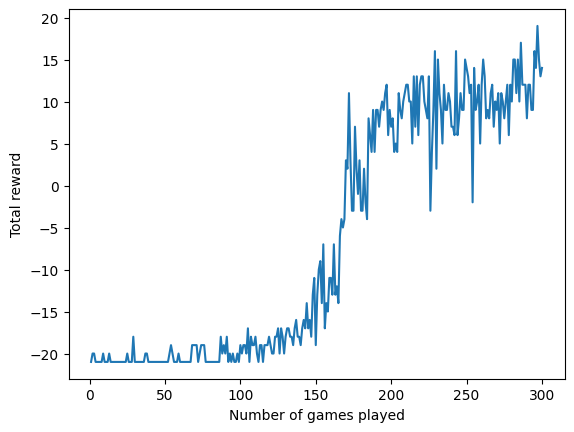

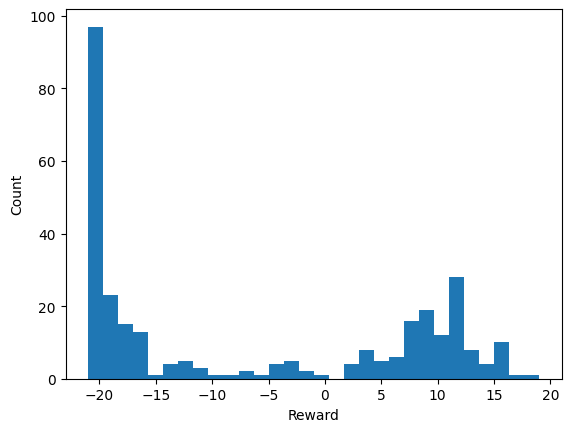

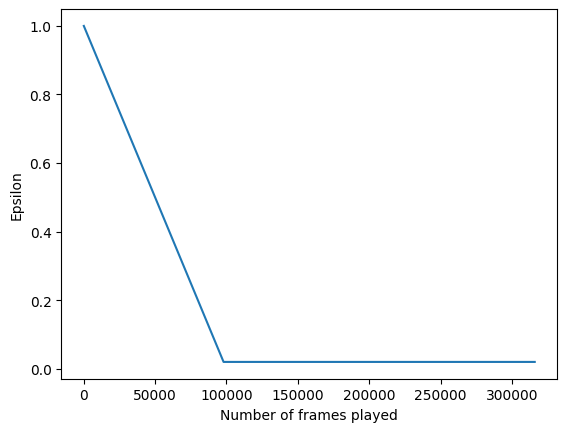

In [104]:
plt.plot(num_games, mean_rewards)
plt.xlabel('Number of games played')
plt.ylabel('Mean reward')
plt.show()

plt.plot(range(1, len(total_rewards)+1), total_rewards)
plt.xlabel('Number of games played')
plt.ylabel('Total reward')
plt.show()

plt.hist(total_rewards, bins=30)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.show()

plt.plot(frames, epsilons)
plt.xlabel('Number of frames played')
plt.ylabel('Epsilon')
plt.show()